Willis Nachricht Stand: 28.03.25

GeoTiffs sollen folgendes enthalten:
- Versiegelten Flächen (sealing) in % -> Konstanz_08335043_germany_2024_sealing_25832.tif
- Beschirmungsgrad (canopy cover, cc) in %  -> Konstanz_08335043_germany_2024_cc_25832.tif
- Grünvolumen (gv) in m³ / 100m²            -> Konstanz_08335043_germany_2024_gv_25832.tif
- Vegetationshöhe (vh) in m                 -> Konstanz_08335043_germany_2024_vh_25832.tif
- Bebauten Flächen (Built-up) in %          -> Konstanz_Built-Up_2018_CLMS.ti

**Rasterio:**
- zeigt dir was auf einer Fläche liegt (z. B. Versieglung, Vegetation)
- arbeitet mit Rasterdaten (Pixel) - z. B. Luftbilder, Höhenmodelle	

**GeoPandas:**
- zeigt dir wo die Fläche ist (z. B. Grundstücke, Stadtgrenzen)
- arbeitet mit Vektordaten (Punkte, Linien, Flächen) - z. B. Sensormessstelle, Straßen, Flurstücke

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from pyproj import Transformer
import rasterio

In [2]:


# Pfad zur GeoTIFF-Datei (anpassen, falls nötig)
file_path = "maja_geodaten/Konstanz_08335043_germany_2024_vh_25832.tif"

# Öffne die GeoTIFF-Datei
with rasterio.open(file_path) as src:
    # NumPy 2D-Array (Werte pro Pixel)
    band = src.read(1)
    # Allgemeine Metadaten
    meta = src.meta
    # Geografische Ausdehnung (Bounding Box)
    bounds = src.bounds
    # Koordinatensystem (z. B. EPSG:25832)
    crs = src.crs
    # Affine Transformation: beschreibt Position, Auflösung, Ausrichtung
    transform = src.transform
    # Breite und Höhe in Pixeln
    width = src.width
    height = src.height
    # Anzahl der Bänder (z. B. 1 für Graustufenbilder)
    band_count = src.count
    # Datentyp der Pixelwerte (z. B. float32, uint8)
    dtype = src.dtypes
    # Treiber/Format der Datei (z. B. 'GTiff')
    driver = src.driver
    # Auflösung in X- und Y-Richtung (z. B. 10x10 Meter)
    res = src.res
    # NoData-Wert (falls definiert)
    nodata = src.nodata

# Sammle alle Infos in einem Dictionary
geo_info = {
    "Dateiformat": driver,
    "Breite (Pixel)": width,
    "Höhe (Pixel)": height,
    # hier 1: monothematisches Raster - jeder Pixel hat genau einen Wert 
    "Anzahl Bänder": band_count,
    "Daten-Typ": dtype[0],
    # Die Auflösung ergibt sich rechnerisch aus Bounding Box (=fixe geografische Ausdehnung) / Pixelanzahl
    "Auflösung (Pixelgröße)": f"{res[0]:.3f} x {res[1]:.3f} m",
    "CRS (Koordinatensystem)": str(crs),
    # ist das kleinste Rechteck, das ein geografisches Objekt oder eine Fläche vollständig umschließt
    "Bounding Box": {
        "Links": bounds.left,
        "Rechts": bounds.right,
        "Unten": bounds.bottom,
        "Oben": bounds.top
    },
    # Übersetzung zwischen Bild und Karte
    # wie du zwischen Pixel- und Weltkoordinaten hin- und herrechnen kannst
    "Affine-Transformation": str(transform),
    "NoData-Wert": nodata,
}

# Ausgabe der gesammelten Informationen
pprint(geo_info, sort_dicts=False)


{'Dateiformat': 'GTiff',
 'Breite (Pixel)': 1016,
 'Höhe (Pixel)': 1227,
 'Anzahl Bänder': 1,
 'Daten-Typ': 'float32',
 'Auflösung (Pixelgröße)': '10.005 x 10.005 m',
 'CRS (Koordinatensystem)': 'EPSG:25832',
 'Bounding Box': {'Links': 506301.8412973635,
                  'Rechts': 516467.0004072579,
                  'Unten': 5277755.279033793,
                  'Oben': 5290031.509573006},
 'Affine-Transformation': '| 10.01, 0.00, 506301.84|\n'
                          '| 0.00,-10.01, 5290031.51|\n'
                          '| 0.00, 0.00, 1.00|',
 'NoData-Wert': nan}


In [3]:
band.shape

(1227, 1016)

In [4]:

# Zeilen & Spalten in Koordinaten umrechnen
rows, cols = band.shape # (1227, 1016)

# Alle Spalten- und Zeilenindizes generieren
col_indices = np.arange(cols)
row_indices = np.arange(rows)

# X- und Y-Koordinaten für jede Spalte und Zeile
x_coords = np.array([transform * (c, 0) for c in col_indices])[:, 0]
y_coords = np.array([transform * (0, r) for r in row_indices])[:, 1]

# Gitter aus X, Y, Wert erzeugen
xx, yy = np.meshgrid(x_coords, y_coords)

# Werte und Koordinaten in DataFrame bringen
df = pd.DataFrame({
    "x": xx.flatten(),
    "y": yy.flatten(),
    "value": band.flatten()
})

# Beispielausgabe
print(df.head())

               x             y  value
0  506301.841297  5.290032e+06    NaN
1  506311.846375  5.290032e+06    NaN
2  506321.851453  5.290032e+06    NaN
3  506331.856531  5.290032e+06    NaN
4  506341.861609  5.290032e+06    NaN


In [5]:
print(df.shape)
df.info()

(1246632, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246632 entries, 0 to 1246631
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1246632 non-null  float64
 1   y       1246632 non-null  float64
 2   value   590564 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 23.8 MB


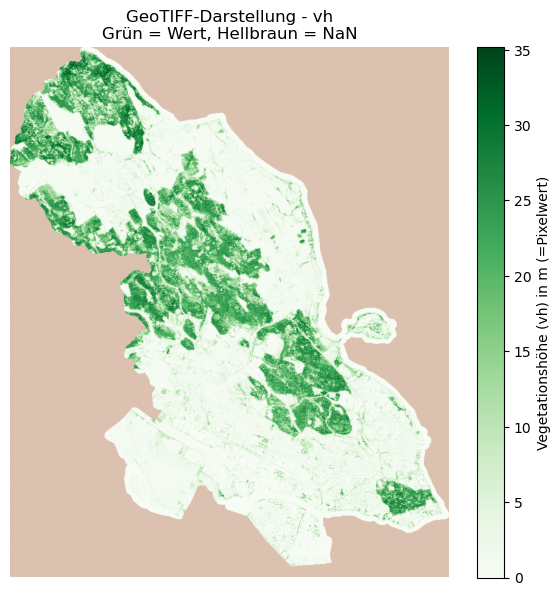

In [6]:

# Farbskala: "Greens" für Werte, "Hellbraun" für NaNs
greens = plt.cm.Greens
custom_cmap = greens.with_extremes(bad="#DCC1B0")

plot_kind = "vh"
# Plot erstellen
plt.figure(figsize=(6, 6))
plt.imshow(band, cmap=custom_cmap)
plt.title(f"GeoTIFF-Darstellung - {plot_kind}\nGrün = Wert, Hellbraun = NaN")
plt.colorbar(label="Vegetationshöhe (vh) in m (=Pixelwert)")
plt.axis("off")
plt.tight_layout()

# Optional: Bild speichern
plt.savefig(f"maja_geodaten/images/geotiff_darstellung_{plot_kind}.png", dpi=300, bbox_inches='tight')  # <- optional
plt.show()


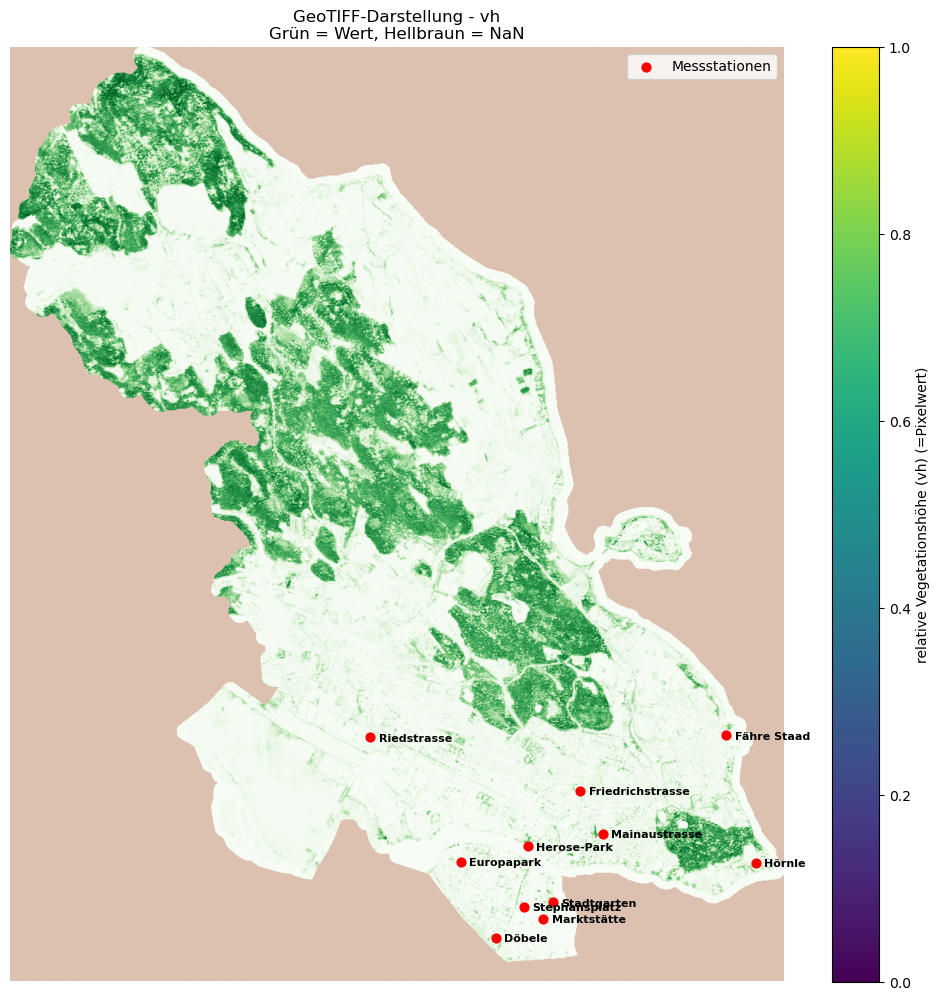

In [7]:

# === 1. Pfade zur Datei ===
tif_path = "maja_geodaten/Konstanz_08335043_germany_2024_vh_25832.tif"
csv_path = "maja_geodaten/messstationen_Konstanz_meta.csv"

# === 2. GeoTIFF öffnen ===
with rasterio.open(tif_path) as src:
    band = src.read(1)              # Bilddaten (Band 1)
    transform = src.transform       # Affine-Transformation
    crs = src.crs                   # Koordinatensystem (z. B. EPSG:25832)
    bounds = src.bounds             # Bounding Box

# === 3. Messstationen laden ===
stations_df = pd.read_csv(csv_path, sep=';')

# === 4. Koordinaten transformieren (von WGS84 zu Raster-CRS) ===
transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
stations_df["X"], stations_df["Y"] = transformer.transform(
    stations_df["Geogr.Laenge"].values,
    stations_df["Geogr.Breite"].values
)

# === 5. Farbskala definieren ===
greens = plt.cm.Greens
custom_cmap = greens.with_extremes(bad="#DCC1B0")  # NaNs = braun

# === 6. Plot erzeugen ===
plt.figure(figsize=(10, 10))

# Raster anzeigen mit korrekter Georeferenzierung
plt.imshow(band, cmap=custom_cmap, extent=(
    bounds.left, bounds.right, bounds.bottom, bounds.top))

# Stationen als rote Punkte einzeichnen
plt.scatter(stations_df["X"], stations_df["Y"], c='red', s=40, label="Messstationen")

# Namen der Stationen beschriften
for _, row in stations_df.iterrows():
    plt.text(row["X"] + 110, row["Y"] - 50, row["name"], color='black', fontsize=8, weight='bold')

# Plot-Dekoration
plt.title(f"GeoTIFF-Darstellung - {plot_kind}\nGrün = Wert, Hellbraun = NaN")
plt.colorbar(label="relative Vegetationshöhe (vh) (=Pixelwert)")
plt.axis("off")
plt.tight_layout()
plt.legend()

# === 7. Optional: Bild speichern ===
plt.savefig(f"maja_geodaten/images/geotiff_darstellung_{plot_kind}.png", dpi=300, bbox_inches='tight')  # <- optional
plt.show()


Ziel: Funktionen Schreiben um einen Radius um die Punkte zu ziehen und die Werte herauszuschneiden

Problem: Aus irgendeinem Grund funktioniert der Code nur für Fähre Staad...

In [8]:

def load_stations(csv_path: str, target_crs: str) -> pd.DataFrame:
    """
    Lädt eine CSV-Datei mit Messstationen und transformiert die Koordinaten ins Ziel-Koordinatensystem.

    Args:
        csv_path (str): Pfad zur CSV-Datei mit Spalten 'name', 'Geogr.Laenge', 'Geogr.Breite'
        target_crs (str): Ziel-Koordinatensystem (z. B. "EPSG:25832")

    Returns:
        pd.DataFrame: Tabelle mit zusätzlichen Spalten 'X' und 'Y' im Ziel-CRS
    """
    df = pd.read_csv(csv_path, sep=';')
    #display(df)
    # WGS84 → Ziel-Koordinatensystem (z. B. UTM)
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    df["X"], df["Y"] = transformer.transform(df["Geogr.Laenge"].values, df["Geogr.Breite"].values)
    display(df)
    return df

def extract_values_around_station(src, band, x_center, y_center, station_name, radius_m) -> list:
    """
    Extrahiert alle Rasterwerte innerhalb eines kreisförmigen Umkreises um eine einzelne Station.

    Args:
        src (rasterio.io.DatasetReader): Geöffnete Rasterdatei
        band (np.ndarray): 2D-Array mit Rasterdaten
        x_center (float): X-Koordinate der Station (im CRS des Rasters)
        y_center (float): Y-Koordinate der Station (im CRS des Rasters)
        station_name (str): Name der Station
        radius_m (float): Radius in Metern für den Suchbereich

    Returns:
        list: Liste mit Dictionaries (station, x, y, value)
    """
    values = []

    # Auflösung der Rasterdaten (Pixelgröße)
    res_x, res_y = src.res

    # Mittelpunkt in Raster-Pixeln
    col_center, row_center = src.index(x_center, y_center)
    pixel_radius = int(np.ceil(radius_m / res_x))

    # Iteriere über Pixel in quadratischem Fenster
    for dy in range(-pixel_radius, pixel_radius + 1):
        for dx in range(-pixel_radius, pixel_radius + 1):
            r = row_center + dy
            c = col_center + dx

            # Stelle sicher, dass wir im Bildbereich bleiben
            if 0 <= r < band.shape[0] and 0 <= c < band.shape[1]:
                
                # Entfernung zum Mittelpunkt berechnen
                dist = np.sqrt((dx * res_x)**2 + (dy * res_y)**2)
                if dist <= radius_m:
                    print("Test: dist - ", station_name)
                    val = band[r, c]
                    if not np.isnan(val):
                        # Reelle Koordinaten des Pixels berechnen
                        x, y = src.transform * (c, r)
                        print("Test: isna - ", station_name)
                        values.append({
                            "station": station_name,
                            "x": x,
                            "y": y,
                            "value": val
                        })
                        print(values)

    return values

def extract_raster_values_near_stations(tif_path: str, csv_path: str, radius_m: float) -> pd.DataFrame:
    """
    Extrahiert Rasterwerte im Umkreis eines Radius um jede Messstation aus einer GeoTIFF-Datei.

    Args:
        tif_path (str): Pfad zur GeoTIFF-Datei
        csv_path (str): Pfad zur CSV-Datei mit den Messstationen
        radius_m (float): Radius in Metern um jede Station

    Returns:
        pd.DataFrame: DataFrame mit Spalten ['station', 'x', 'y', 'value']
    """
    with rasterio.open(tif_path) as src:
        # Rasterdaten & Stationen laden
        band = src.read(1)
        stations_df = load_stations(csv_path, str(src.crs))

        all_values = []

        # Für jede Station Werte im Umkreis extrahieren
        for _, row in stations_df.iterrows():
            #print(row["name"])
            vals = extract_values_around_station(
                src, band,
                x_center=row["X"],
                y_center=row["Y"],
                station_name=row["name"],
                radius_m=radius_m
            )
            all_values.extend(vals)

    return pd.DataFrame(all_values)



station_50m_df = extract_raster_values_near_stations(tif_path, csv_path, 50)
station_50m_df

,name,Geogr.Laenge,Geogr.Breite,X,Y
0,Döbele,9.168898,47.658239,512682.043346,5.278330e+06
1,Europapark,9.162823,47.667215,512223.786334,5.279326e+06
2,Fähre Staad,9.209338,47.682119,515711.337143,5.280991e+06
3,Friedrichstrasse,9.183755,47.675575,513793.008422,5.280259e+06
4,Herose-Park,9.174574,47.669055,513105.522594,5.279533e+06
5,Hörnle,9.214489,47.667024,516102.633651,5.279315e+06
6,Mainaustrasse,9.187752,47.670510,514094.422039,5.279697e+06
7,Marktstätte,9.177239,47.660473,513307.721308,5.278580e+06
8,Riedstrasse,9.147058,47.681976,511037.103849,5.280965e+06
9,Stadtgarten,9.178891,47.662419,513431.313698,5.278796e+06


Test: dist -  Fähre Staad
Test: isna -  Fähre Staad
[{'station': 'Fähre Staad', 'x': 515316.4164528899, 'y': 5280666.756692237, 'value': 0.72284764}]
Test: dist -  Fähre Staad
Test: isna -  Fähre Staad
[{'station': 'Fähre Staad', 'x': 515316.4164528899, 'y': 5280666.756692237, 'value': 0.72284764}, {'station': 'Fähre Staad', 'x': 515326.42153075396, 'y': 5280666.756692237, 'value': 0.91923994}]
Test: dist -  Fähre Staad
Test: isna -  Fähre Staad
[{'station': 'Fähre Staad', 'x': 515316.4164528899, 'y': 5280666.756692237, 'value': 0.72284764}, {'station': 'Fähre Staad', 'x': 515326.42153075396, 'y': 5280666.756692237, 'value': 0.91923994}, {'station': 'Fähre Staad', 'x': 515336.42660861806, 'y': 5280666.756692237, 'value': 1.7141252}]
Test: dist -  Fähre Staad
Test: isna -  Fähre Staad
[{'station': 'Fähre Staad', 'x': 515316.4164528899, 'y': 5280666.756692237, 'value': 0.72284764}, {'station': 'Fähre Staad', 'x': 515326.42153075396, 'y': 5280666.756692237, 'value': 0.91923994}, {'station

,station,x,y,value
0,Fähre Staad,515316.416453,5.280667e+06,0.722848
1,Fähre Staad,515326.421531,5.280667e+06,0.919240
2,Fähre Staad,515336.426609,5.280667e+06,1.714125
3,Fähre Staad,515346.431686,5.280667e+06,1.332073
4,Fähre Staad,515356.436764,5.280667e+06,1.242310
...,...,...,...,...
64,Fähre Staad,515316.416453,5.280587e+06,0.945458
65,Fähre Staad,515326.421531,5.280587e+06,1.705690
66,Fähre Staad,515336.426609,5.280587e+06,0.502355
67,Fähre Staad,515346.431686,5.280587e+06,0.192690


In [9]:
station_50m_df.station.unique()

array(['Fähre Staad'], dtype=object)